In [212]:
import os, os.path as op, pandas as pd, numpy as np
from glob import glob
import seaborn as sns
u = lambda x: list(set(x))
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import pingouin as pg

sns.set_palette("colorblind")
sns.set(font="Helvetica")
flatten = lambda t: [item for sublist in t for item in sublist]
def tryconvert(value, default=int, if_error=np.nan):
    try:
        return default(value)
    except (ValueError, TypeError):
        return if_error

def tryconvertList(lst, default=int, if_error=np.nan):
    vals = []
    for val in lst:
        try:
            vals.append(default(val))
        except:
            vals.append(if_error)
    return vals
    
def handleKeyError(value, if_error):
    try:
        return value
    except KeyError:
        return if_error
    
import statsmodels.stats.api as sms

def createPairs(numbers):
    prs = []
    for i, num in enumerate(numbers):
        if i == len(numbers)-1:
            pass
        else:
            prs.append((num, numbers[i+1]))
    return prs
            
def SDT(hits, misses, fas, crs):
    from scipy.stats import norm
    import math
    Z = norm.ppf
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / (hits + misses)
    half_fa = 0.5 / (fas + crs)

    # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit

    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa

    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hit_rate) - Z(fa_rate)
    out['beta'] = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    out['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    out['Ad'] = norm.cdf(out['d'] / math.sqrt(2))

    return(out)

tps = ['tp-1','tp0', 'tp1', 'tp2']
logs = {tps[i]:glob(f"data/{tps[i]}/*.log") for i in range(len(tps))}
tasks = ["DD6Mixed"]
participants = sorted(u([op.split(e)[-1].split('-')[0].split("_")[0] for e in glob("data/tp2/*.log")]))
cblind = sns.color_palette("colorblind", 50)

In [229]:
dfs = {}
dGroupAll = pd.DataFrame({k:[] for k in ['blockType', 'tp', 'task']})
dPartAll = {}
for task in tasks:
    dGroup = pd.DataFrame()
    #task = "LDTVisL1"
    for p in participants:
#          if p != 'BISAM316':
#             pass
#          else:
        try:
            dPartAll[p] = pd.DataFrame({k:[] for k in ['subject','blockType','tp','percCorrect','nStim','nCorrect','nIncorrect']})
            dfs[p] = {}
            fls = []
            for tp in tps:
                fls.append([f for f in logs[tp] if p in f])
            fls = flatten(fls)
            if len([pd.read_csv(f, skiprows=3, sep = "\t") for f in fls if task in f]) > 2:
                dfs[p][task] = pd.concat([pd.read_csv(f, skiprows=3, sep = "\t") for f in fls if task in f])
                dfs[p][task].columns = [c.lower() for c in list(dfs[p][task].columns)]
                dfs[p][task] = dfs[p][task][(dfs[p][task]["subject"].str.contains(p)) &
                                            (~dfs[p][task]["subject"].str.contains("subject")) ]
                dfs[p][task]["tp"] = dfs[p][task]["subject"].apply(lambda x: x.split("_")[-1].lower()
                                                                   if "tp" in x.split("_")[-1].lower()
                                                                   else "tp-1")
                dfs[p][task]["subject"] = dfs[p][task]["subject"].apply(lambda x: x.split("_")[0])
                dfs[p][task] = dfs[p][task].reset_index(drop=True)
                dfs[p][task]["code"] = dfs[p][task]["code"].apply(lambda x: str(x))
                filt = dfs[p][task][(dfs[p][task]["code"].str.contains("DD6Mix")) &
                 (~dfs[p][task]["code"].str.contains("ses-tp")) &
                (~dfs[p][task]["code"].str.contains("EMPTY"))].index
                dfs[p][task].loc[filt,"code"] = dfs[p][task].loc[filt,:].apply(lambda x: f'ses-{x["tp"]}_task-DD6Mix_word-{x["code"].split("_")[-1]}_corrans-t'
                if "#" in x["code"] else f'ses-{x["tp"]}_task-DD6Mix_word-{x["code"].split("_")[-1]}_corrans-n',
                                                             axis=1)
                    
                numbers = np.append(np.array(dfs[p][task][(dfs[p][task]["code"].str.contains("DD6Mix")) &
                (~dfs[p][task]["code"].str.contains("EMPTY"))].index),
              np.array(dfs[p][task][(dfs[p][task]["code"].str.contains("BLOCK_END"))].index)[-1])
                pairs = createPairs(numbers)
                dd6part = pd.DataFrame({k:[] for k in ['subject','tp','code','nPresses']})
                for pair in pairs:
                    _d = dfs[p][task].iloc[pair[0]:pair[1],:]
                    dd6part = dd6part.append({'subject':_d.iloc[0,:]["subject"],
                                              'tp':_d.iloc[0,:]["tp"],
                                             'code':_d.iloc[0,:]["code"].split("word-")[-1].split("_")[0],
                                             'nPresses':len(_d[_d["event type"] == 'Response'])},
                                            ignore_index=True)
                    dd6part["nHash"] = dd6part.apply(lambda x: len([h for h in x['code'] if h == "#"]), axis=1)
                dd6part["nMiss"] = dd6part.apply(lambda x: x["nHash"] - x["nPresses"] if (x["nHash"] - x["nPresses"]) > 0
                                                                   else 0, axis = 1)
                dd6part["nFA"] = dd6part.apply(lambda x: abs((x["nHash"] - x["nPresses"]))
                                                      if (x["nHash"] - x["nPresses"]) < 0
                                                                   else 0, axis = 1)
                dd6part['nHit'] = dd6part["nHash"] - dd6part['nMiss']
                dd6part["nCR"] = 5 - dd6part["nHash"] - dd6part["nPresses"]
                _stat = dd6part.groupby(['subject','tp']).agg(
                                                                nMiss = ("nMiss",np.sum),
                                                                nHit = ("nHit",np.sum),
                                                                nFA = ("nFA",np.sum),
                                                                nCR = ("nCR",np.sum)).reset_index()
                _stat["Hit"] = _stat["nHit"]/(_stat["nHit"]+_stat["nMiss"])
                _stat["Miss"] = _stat["nMiss"]/(_stat["nHit"]+_stat["nMiss"])
                _stat["FA"] = _stat["nFA"]/(_stat["nFA"]+_stat["nCR"])
                _stat["CR"] = _stat["nCR"]/(_stat["nFA"]+_stat["nCR"])
                for stat in ['d','beta','c','Ad']:
                    _stat[stat] = _stat.apply(lambda x: SDT(x['Hit'],x['Miss'],x['FA'],x['CR'])[stat],axis=1)
                dGroup = pd.concat([dGroup, _stat])
                dGroup['group'] = dGroup['subject'].apply(lambda x: "Control" if int(x.split("BISAM")[-1]) > 300 else "Braille")
                dGroup = dGroup.sort_values(["subject", 'tp'],ascending=[True,True]).reset_index(drop=True)
                
                dGroupLong = pd.melt(dGroup,id_vars = ["subject","group","tp"],value_vars = ['d','beta','c','Ad'],
                                     var_name = 'stat')
        except:
            print(f"{p} - error")
            pass
dGroup = dGroup.append({"tp":"tp-1","group":"Control"}, ignore_index=True)
dGroupLong = pd.melt(dGroup,id_vars = ["subject","group","tp"],value_vars = ['d','beta','c','Ad'],
                                     var_name = 'stat')

In [209]:
dGroupLong = pd.melt(dGroup,id_vars = ["subject","group","tp"],value_vars = ["Hit","Miss","FA","CR"],
                                     var_name = 'stat')

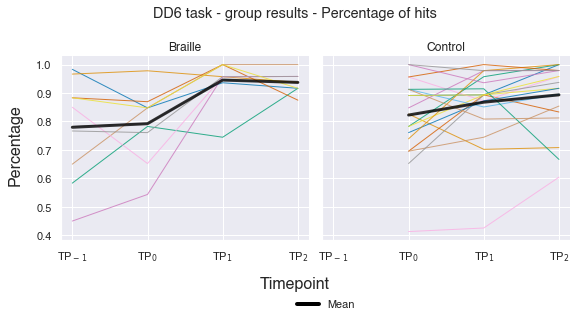

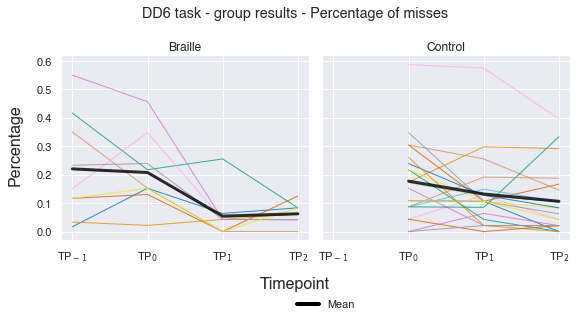

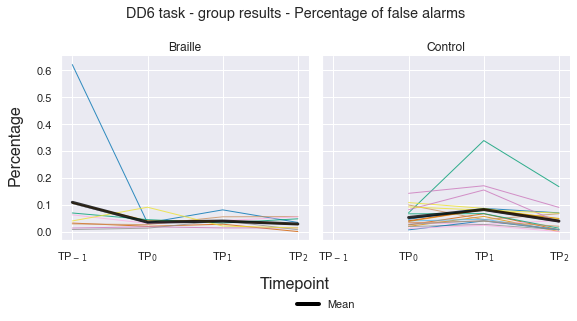

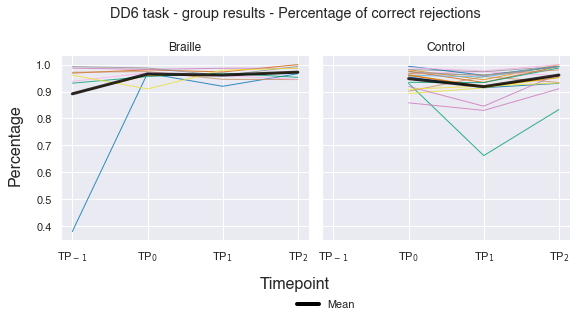

In [210]:
descs = ['hits',"misses","false alarms","correct rejections"]
for i, vrbl in enumerate(['Hit',"Miss","FA","CR"]):

    dGroup['tpINT'] = dGroup['tp'].apply(lambda x: int(x.split("tp")[-1]))
    g = sns.FacetGrid(dGroup, col = 'group', hue='group', height=4, aspect=1,sharex=True, sharey='row',
                 col_order = ["Braille","Control"], palette='colorblind')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'DD6 task - group results - Percentage of {descs[i]}')
    #g.fig.suptitle(f'DD6 - group results (n = {dTemp["subject"].unique().size})')
    g.map(sns.lineplot,'tpINT', vrbl, "subject",alpha = .8, sort=False,lw=1,palette='colorblind')
    g.map(sns.lineplot,'tpINT', vrbl, color='black',alpha = .8, sort=False,lw=3,ci=False)
    axes = g.axes.flatten()
    j = 0
    for i in range(len(axes)):
        if i % 2 == 0:
            axes[i].set_title(f"Braille")
        else:
            axes[i].set_title(f"Control") 
            j += 1
    #axes[1].set_title("Control")


    g.set(xticks=[-1,0,1,2])
    g.set_xticklabels([r'TP$_-$$_1$',r'TP$_0$',r'TP$_1$',r'TP$_2$'])

    patch = Line2D([0], [0], color='black', lw=4,label="Mean")
    plt.legend(handles = [patch], labels = ["Mean"],
               borderaxespad=0.,ncol=3,loc='best', bbox_to_anchor=(.15, -.30, 0, 0),frameon=False)

    g.set_axis_labels('', '') 

    # overall ylabel
    g.fig.text(x=0, y=0.5, 
               verticalalignment='center', #make sure it's aligned at center vertically
               s="Percentage", #this is the text in the ylabel
               size=16, #customize the fontsize if you will
               rotation=90) #vertical text

    #overall xlabel
    g.fig.text(x=0.5, y=0, 
               horizontalalignment='center', #make sure it's aligned at center horizontally
               s='Timepoint', #this is the text in the xlabel
               size=16)
    plt.savefig(f"DD6_group_{vrbl}.png",dpi=400,bbox_inches='tight',transparent=False)

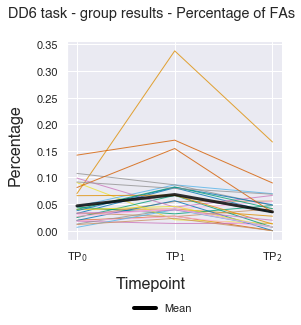

In [242]:
descs = ['FAs']
for i, vrbl in enumerate(['FA']):

    dGroup['tpINT'] = dGroup['tp'].apply(lambda x: int(x.split("tp")[-1]))
    dGroupX = dGroup[dGroup.tp.isin(['tp0','tp1','tp2'])]
    g = sns.FacetGrid(dGroupX, height=4, aspect=1,sharex=True, sharey='row', palette='colorblind')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'DD6 task - group results - Percentage of {descs[i]}')
    #g.fig.suptitle(f'DD6 - group results (n = {dTemp["subject"].unique().size})')
    g.map(sns.lineplot,'tpINT', vrbl, "subject",alpha = .8, sort=False,lw=1,palette='colorblind')
    g.map(sns.lineplot,'tpINT', vrbl, color='black',alpha = .8, sort=False,lw=3,ci=False)
    #axes[1].set_title("Control")


    g.set(xticks=[0,1,2])
    g.set_xticklabels([r'TP$_0$',r'TP$_1$',r'TP$_2$'])

    patch = Line2D([0], [0], color='black', lw=4,label="Mean")
    plt.legend(handles = [patch], labels = ["Mean"],
               borderaxespad=0.,ncol=3,loc='best', bbox_to_anchor=(.6, -.30, 0, 0),frameon=False)

    g.set_axis_labels('', '') 

    # overall ylabel
    g.fig.text(x=0, y=0.5, 
               verticalalignment='center', #make sure it's aligned at center vertically
               s="Percentage", #this is the text in the ylabel
               size=16, #customize the fontsize if you will
               rotation=90) #vertical text

    #overall xlabel
    g.fig.text(x=0.5, y=0, 
               horizontalalignment='center', #make sure it's aligned at center horizontally
               s='Timepoint', #this is the text in the xlabel
               size=16)
    plt.savefig(f"DD6_noGroup_{vrbl}.png",dpi=400,bbox_inches='tight',transparent=False)

In [ ]:
dGroupLong[dGroupLong.stat.isin(['Hit',"Miss","FA","CR"])]

In [230]:
dGroupAOV = dGroup[dGroup['tp'].isin(['tp0','tp1','tp2'])]

In [223]:
(pg.mixed_anova(data = dGroupAOV, dv = 'Hit', between = "group", within = "tp", subject = "subject")
 .round(3).to_excel("mixedAOV.xlsx"))

In [224]:
(pg.pairwise_ttests(data = dGroupAOV, dv = 'Hit', between = "group", within = "tp", subject = "subject",
                  padjust='sidak').round(3).to_excel("mixedAOVSSidak.xlsx"))

In [234]:
(pg.mixed_anova(data = dGroupAOV, dv = 'FA', between = "group", within = "tp", subject = "subject")
.round(3).to_excel("mixedAOV2.xlsx"))

In [237]:
pg.mixed_anova(data = dGroupAOV, dv = 'FA', between = "group", within = "tp", subject = "subject")

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,0.010269,1,26,0.010269,2.361541,0.136441,0.083266,NaN
1,tp,0.015265,2,52,0.007632,7.764268,0.001121,0.229955,0.711953
2,Interaction,0.003477,2,52,0.001739,1.768572,0.180682,0.063690,NaN


In [236]:
(pg.pairwise_ttests(data = dGroupAOV, dv = 'FA', between = "group", within = "tp", subject = "subject",
                  padjust='sidak').round(3).to_excel("mixedAOVSidak2.xlsx"))

Text(0.5, 0, 'Timepoint')

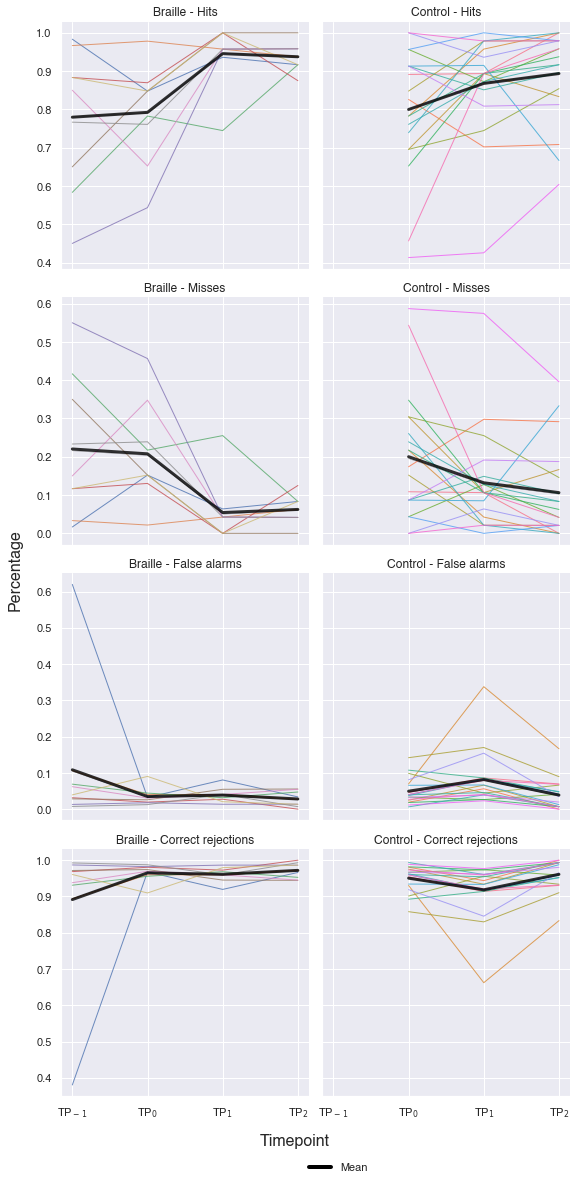

In [180]:
dGroupX = dGroupLong[dGroupLong.stat.isin(['Hit',"Miss","FA","CR"])]
rowOrder = ['Hits',"Misses","False alarms","Correct rejections"]
dGroupX['tpINT'] = dGroupX['tp'].apply(lambda x: int(x.split("tp")[-1]))
g = sns.FacetGrid(dGroupX, col = 'group', row = "stat", hue='group', height=4, aspect=1,sharex=True, sharey='row',
             col_order = ["Braille","Control"],
             row_order = ['Hit',"Miss","FA","CR"])
plt.subplots_adjust(top=0.9)
#g.fig.suptitle(f'Lexical decision tasks - group results (n = {dGroupAll["subject"].unique().size})')
#g.fig.suptitle(f'DD6 - group results (n = {dTemp["subject"].unique().size})')
g.map(sns.lineplot,'tpINT', 'value', "subject",alpha = .8, sort=False,lw=1,)
g.map(sns.lineplot,'tpINT', 'value',color='black',alpha = .8, sort=False,lw=3,ci=False)
axes = g.axes.flatten()
j = 0
for i in range(len(axes)):
    if i % 2 == 0:
        axes[i].set_title(f"Braille - {rowOrder[j]}")
    else:
        axes[i].set_title(f"Control - {rowOrder[j]}") 
        j += 1
#axes[1].set_title("Control")


g.set(xticks=[-1,0,1,2])
g.set_xticklabels([r'TP$_-$$_1$',r'TP$_0$',r'TP$_1$',r'TP$_2$'])

patch = Line2D([0], [0], color='black', lw=4,label="Mean")
plt.legend(handles = [patch], labels = ["Mean"],
           borderaxespad=0.,ncol=3,loc='best', bbox_to_anchor=(.20, -.25, 0, 0),frameon=False)

g.set_axis_labels('', '') 

# overall ylabel
g.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s="Percentage", #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
g.fig.text(x=0.5, y=0, 
           horizontalalignment='center', #make sure it's aligned at center horizontally
           s='Timepoint', #this is the text in the xlabel
           size=16)

No handles with labels found to put in legend.


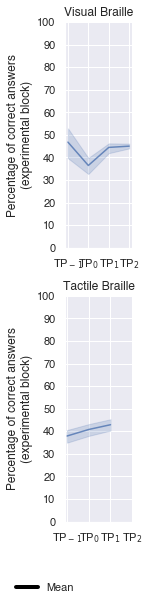

In [121]:

g = sns.FacetGrid(dGroup, row = 'group', height=4, aspect=.5,sharex=False, sharey=True,
             row_order = ["Braille","Control"])
plt.subplots_adjust(top=0.9)
#g.fig.suptitle(f'Lexical decision tasks - group results (n = {dGroupAll["subject"].unique().size})')
#g.fig.suptitle(f'DD6 - group results (n = {dTemp["subject"].unique().size})')
g.map(sns.lineplot,'tp', 'nHit',
      palette =[cblind[i] for i in [0,1,4,5]],alpha = .8, sort=False)
# g.map(sns.lineplot,'tp', 'percCorrect',
#       color='black',alpha = .8, lw=3)

#g.map(lambda x, **kw: sns.lineplot(x.groupby(['task','tp'])['percCorrect'].mean()),'percCorrect')

#g = g.map(lambda y, **kw: plt.axhline(y.mean(), color="k"), 'percCorrect')
#g = g.map(lambda x, ** kw: sns.lineplot(x), 'meandesc', ls=":", c=".5")
g.set_axis_labels("", "Percentage of correct answers\n(experimental block)")
axes = g.axes.flatten()
axes[0].set_title("Visual Braille")
axes[1].set_title("Tactile Braille")
g.set_xticklabels([r'TP$_-$$_1$',r'TP$_0$',r'TP$_1$',r'TP$_2$'])
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['3 letters','4 letters','5 letters']
from matplotlib.lines import Line2D
# manually define a new patch 
patch = Line2D([0], [0], color='black', lw=4,label="Mean")
# handles is a list, so append manual patch
#handles.append(patch) 

for (i,j,k), data in g.facet_data():
    if data.empty:
        ax = g.facet_axis(i, j)
        ax.set_axis_off()
#handles, labels = g.axes.flatten().get_legend_handles_labels()
# plot the legend
#plt.legend(, loc='upper center')
leg = plt.legend(handles=handles, labels = labels, borderaxespad=0.,ncol=3,loc='best', bbox_to_anchor=(1, -.15, 0, 0),frameon=False)
plt.gca().add_artist(leg)
plt.legend(handles = [patch], labels = ["Mean"], borderaxespad=0.,ncol=3,loc='best', bbox_to_anchor=(.20, -.25, 0, 0),frameon=False)
g.set(yticks=(list(np.arange(0,101,10))))
g.savefig("ldtResGroup.jpg",dpi=300,bbox_inches='tight',transparent=False)
#plt.close()

AttributeError: 'AxesSubplot' object has no attribute 'flatten'

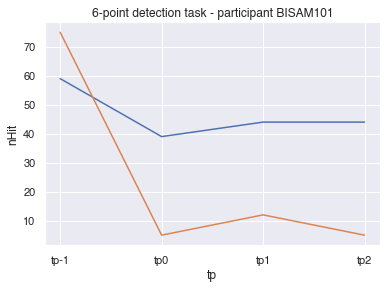

In [99]:
for p in dGroup.subject.unique():
    _d = dGroup[dGroup.subject == p]
    
    g = sns.lineplot(x=_d['tp'],y=_d['nHit'])
    g2 = sns.lineplot(x=_d['tp'],y=_d['nFA'])
    plt.subplots_adjust(top=0.9)
    plt.title(f'6-point detection task - participant {p}')
    #g.set_axis_labels("", "Value")
    axes = g.axes.flatten()
    plt.yticks(range(0,101,10))
    break

In [53]:
dGroup.groupby('tp')['Hit'].mean()

tp
tp-1    0.795000
tp0     0.810870
tp1     0.912766
Name: Hit, dtype: float64

In [55]:
dGroup.groupby('tp')['Hit'].std()

tp
tp-1    0.178998
tp0     0.134810
tp1     0.127837
Name: Hit, dtype: float64

In [30]:
dGroup

,subject,tp,nMiss,nHit,nFA,nCR,Hit,Miss,FA,CR,d,beta,c,Ad
0,BISAM101,tp-1,1.0,59.0,75.0,46.0,0.983333,0.016667,0.619835,0.380165,1.822999,0.108853,-1.216546,0.901310
1,BISAM101,tp0,7.0,39.0,5.0,150.0,0.847826,0.152174,0.032258,0.967742,2.875751,3.258058,0.410721,0.978997
2,BISAM101,tp1,3.0,44.0,11.0,138.0,0.936170,0.063830,0.073826,0.926174,2.971275,0.893873,-0.037759,0.982180
3,BISAM102,tp-1,2.0,58.0,13.0,109.0,0.966667,0.033333,0.106557,0.893443,3.078961,0.403915,-0.294434,0.985265
4,BISAM102,tp0,1.0,45.0,6.0,143.0,0.978261,0.021739,0.040268,0.959732,3.766665,0.599693,-0.135753,0.996133
5,BISAM102,tp1,2.0,45.0,5.0,143.0,0.957447,0.042553,0.033784,0.966216,3.549677,1.207173,0.053042,0.993963
6,BISAM103,tp-1,25.0,35.0,10.0,135.0,0.583333,0.416667,0.068966,0.931034,1.693968,2.939693,0.636556,0.884506
7,BISAM103,tp0,10.0,36.0,7.0,151.0,0.782609,0.217391,0.044304,0.955696,2.483823,3.141618,0.460878,0.960484
8,BISAM103,tp1,12.0,35.0,4.0,154.0,0.744681,0.255319,0.025316,0.974684,2.612422,5.440157,0.648367,0.967645
9,BISAM105,tp-1,7.0,53.0,4.0,123.0,0.883333,0.116667,0.031496,0.968504,3.051063,2.768171,0.333715,0.984514


In [37]:
g.set_xlabel("XXX")

<bound method Axes.set_xlabel of <AxesSubplot:title={'center':'6-point detection task: group results ($\\itn$ = 10)'}, xlabel='tp', ylabel='d'>>

ValueError: Could not interpret input 'tp'

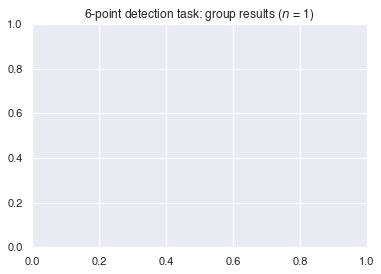

In [12]:

plt.subplots_adjust(top=0.9)
plt.title(fr'6-point detection task: group results ($\itn$ = {dGroupLong["subject"].unique().size})')
g=sns.barplot(data=dGroup,x='tp', y='d',palette = 'colorblind',alpha = .8,errcolor="black")
g.set_xlabel("Timepoint")
g.set_ylabel("d'")
#axes = g.axes.flatten()
#axes[0].set_title("d'")
# axes[1].set_title("Beta")
# axes[2].set_title("C")
# axes[3].set_title("Ad")
g.set_xticklabels([r'TP$_-$$_1$',r'TP$_0$',r'TP$_1$'])

plt.savefig(f"DD6_group.png",dpi=300,bbox_inches='tight', transparent=False)

In [52]:
for p in dGroup.subject.unique():
    _d = dGroup[dGroup.subject == p]
    plt.subplots_adjust(top=0.9)
    plt.title(fr'6-point detection task: participant {p}')
    g=sns.barplot(data=_d,x='tp', y='d',palette = 'colorblind',alpha = .8,errcolor="black")
    g.set_xlabel("Timepoint")
    g.set_ylabel("d'")
    #axes = g.axes.flatten()
    #axes[0].set_title("d'")
    # axes[1].set_title("Beta")
    # axes[2].set_title("C")
    # axes[3].set_title("Ad")
    g.set_xticklabels([r'TP$_-$$_1$',r'TP$_0$',r'TP$_1$'])

    plt.savefig(f"DD6_{p}.png",dpi=300,bbox_inches='tight', transparent=False)
    plt.close()

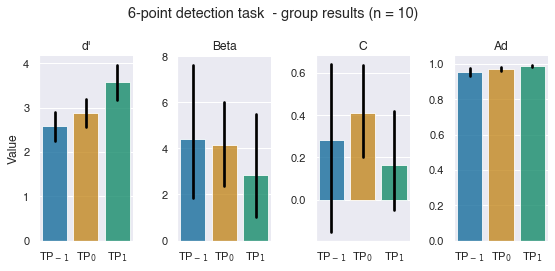

In [219]:
g = sns.FacetGrid(dGroupLong, col="stat", height=4, aspect=.5,sharex=False, sharey=False,
             col_order = ['d','beta','c','Ad'])
plt.subplots_adjust(top=0.9)
g.fig.suptitle(f'6-point detection task  - group results (n = {dGroupLong["subject"].unique().size})')
g.map(sns.barplot,'tp', 'value',palette = 'colorblind',alpha = .8,errcolor="black")
g.set_axis_labels("", "Value")
axes = g.axes.flatten()
axes[0].set_title("d'")
axes[1].set_title("Beta")
axes[2].set_title("C")
axes[3].set_title("Ad")
g.set_xticklabels([r'TP$_-$$_1$',r'TP$_0$',r'TP$_1$'])

In [ ]:



axes = g.axes.flatten()
axes[0].set_title("Visual L1")
axes[1].set_title("Visual Braille")
axes[2].set_title("Tactile Braille")
g.set_xticklabels([r'TP$_-$$_1$',r'TP$_0$',r'TP$_1$'])
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Experimental - % correct','Control - % correct',
         'Experimental - % misses','Control - % misses']

from matplotlib.lines import Line2D
# manually define a new patch 
patch = Line2D([0], [0], color='black', lw=4,label="95% CI")
# handles is a list, so append manual patch
#handles.append(patch) 

for (i,j,k), data in g.facet_data():
    if data.empty:
        ax = g.facet_axis(i, j)
        ax.set_axis_off()
#handles, labels = g.axes.flatten().get_legend_handles_labels()
# plot the legend
#plt.legend(, loc='upper center')
leg = plt.legend(handles=handles, labels = labels, borderaxespad=0.,ncol=2,loc='best', bbox_to_anchor=(.7, -.15, 0, 0),frameon=False)
plt.gca().add_artist(leg)
plt.legend(handles = [patch], labels = ["95% CI"], borderaxespad=0.,ncol=2,loc='best', bbox_to_anchor=(-.5, -.35, 0, 0),frameon=False)
plt.yticks(range(0,101,10))
#plt.show()

plt.savefig(f"LDT_group.png",dpi=300,bbox_inches='tight')
plt.close()

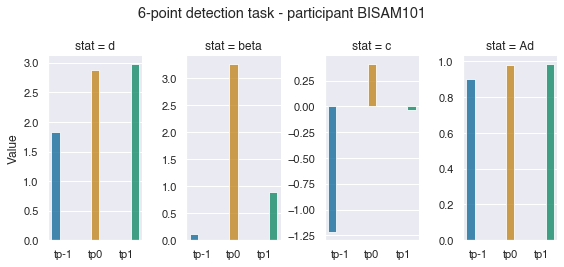

In [216]:
for p in dGroupLong.subject.unique():
    _d = dGroupLong[dGroupLong.subject == p]
    g = sns.FacetGrid(_d, col="stat", height=4, aspect=.5,sharex=False, sharey=False)
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'6-point detection task - participant {p}')
    g.map(sns.barplot,'tp', 'value','tp',palette = 'colorblind',alpha = .8,errcolor="black")
    g.set_axis_labels("", "Value")
    axes = g.axes.flatten()
    break

In [ ]:
for p in dGroupLong.subject.unique():
    _d = dGroupLong[dGroupAll.subject == p]
    g = sns.FacetGrid(_d, col="task", height=4, aspect=.5,sharex=False, sharey=True,
                 col_order = ['d','beta','c','Ad'])
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'6-point detection task - participant {p}')
    g.map(sns.barplot,'tp', 'value','tp',palette = 'colorblind',alpha = .8,errcolor="black")
    g.set_axis_labels("", "Value")
    axes = g.axes.flatten()
    axes[0].set_title("Visual L1")
    axes[1].set_title("Visual Braille")
    axes[2].set_title("Tactile Braille")
    g.set_xticklabels([r'TP$_-$$_1$',r'TP$_0$',r'TP$_1$'])
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ['Experimental - % correct','Control - % correct',
             'Experimental - % misses','Control - % misses']
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()
    #handles, labels = g.axes.flatten().get_legend_handles_labels()
    # plot the legend
    #plt.legend(, loc='upper center')
    plt.legend(handles=handles, labels = labels, borderaxespad=0.,ncol=2,loc='best', bbox_to_anchor=(.7, -.15, 0, 0),frameon=False)
    plt.yticks(range(0,101,10))
    #plt.show()

    plt.savefig(f"LDT_{p}.png",dpi=300,bbox_inches='tight')
    plt.close()

In [17]:
dfs[p][task].head(50)

,subject,trial,event type,code,time,ttime,uncertainty,duration,uncertainty.1,reqtime,reqdur,stim type,pair index,tp
0,BISAM113,0.0,Port Input,6,12038.0,12038.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,tp-1
1,BISAM113,2.0,Pulse,111,251223.0,136974.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,tp-1
2,BISAM113,3.0,Pulse,111,265383.0,14133.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,tp-1
3,BISAM113,3.0,Picture,cue_6point,271333.0,20083.0,1.0,20083.0,1.0,20000.0,20000.0,other,0.0,tp-1
4,BISAM113,3.0,Pulse,111,279463.0,28213.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,tp-1
5,BISAM113,3.0,Pulse,111,293543.0,42293.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,tp-1
6,BISAM113,3.0,Pulse,111,307703.0,56453.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,tp-1
7,BISAM113,4.0,Nothing,BLOCK_START_EXP,321250.0,0.0,0.0,NaN,NaN,0.0,NaN,other,0.0,tp-1
8,BISAM113,5.0,Picture,fix,321333.0,0.0,1.0,10083.0,1.0,0.0,10000.0,other,0.0,tp-1
9,BISAM113,5.0,Pulse,111,321783.0,450.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,tp-1
